## **Table of contents**<a id='toc0_'></a>    
- [Library and Settings](#toc1_1_)    
  - [Install all required library](#toc1_1_1_)    
  - [Import all required library](#toc1_1_2_)    
  - [Import all settings](#toc1_1_3_)    
- [(2) Basic Data Understanding (Visualize some datapoints)](#toc1_2_)    
- [(3) Feature Removal](#toc1_3_)    
- [(4) Exploratory Data Analysis (EDA)](#toc1_4_)    
- [(5) Feature Engineering & Data Preprocessing](#toc1_5_)    
  - [Drop some rows and process datetime data](#toc1_5_1_)    
  - [Train-test split (80% - 20%)](#toc1_5_2_)    
- [(6) Encoding Categorical Data](#toc1_6_)    
  - [A) One-hot encoding method](#toc1_6_1_)    
  - [B) Target encoding method](#toc1_6_2_)    
  - [C) FeatureHasher](#toc1_6_3_)    
- [(7) Model Building & Training](#toc1_7_)    
- [(8) Model Evaluation](#toc1_8_)    
- [(9) Features Important Analysis](#toc1_9_)    
- [(10) Inference Pipeline](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Library and Settings](#toc0_)

### <a id='toc1_1_1_'></a>[Install all required library](#toc0_)

In [1]:
%%capture
!pip install -r requirements.txt

### <a id='toc1_1_2_'></a>[Import all required library](#toc0_)

In [2]:
import warnings
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_extraction import FeatureHasher

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from utility import *

### <a id='toc1_1_3_'></a>[Import all settings](#toc0_)

In [3]:
RPT_PATH = 'data/DataSample.rpt'
INFERENCE_PIPELINE_PATH = 'inference_pipeline'

os.makedirs('data', exist_ok=True)
os.makedirs(INFERENCE_PIPELINE_PATH, exist_ok=True)
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

## <a id='toc1_2_'></a>[(2) Basic Data Understanding (Visualize some datapoints)](#toc0_)

In [4]:
# Read the file with tab delimiter
df = pd.read_csv(RPT_PATH, delimiter='\	', engine='python')

print("DataFrame shape (rows, columns):", df.shape)
df.head(3).T

DataFrame shape (rows, columns): (62192, 130)


,0,1,2
Make,Holden,Holden,Toyota
Model,Commodore,Commodore,RAV4
MakeCode,HOLD,HOLD,TOYO
FamilyCode,COMMODO,COMMODO,RAV4
YearGroup,2008,1993,2012
MonthGroup,0,7,0
SequenceNum,0,41,6
Description,VE Omega Sedan 4dr. Auto 4sp 3.6i,VR Executive Wagon 5dr. Auto 4sp 3.8i,ACA33R MY12 CV Wagon 5dr Man 5sp 4x4 2.4i
CurrentRelease,F,F,F
ImportFlag,L,L,L


In [5]:
print("Number of Sold_Amount > NewPrice", (df['Sold_Amount'] > df['NewPrice']).sum())
# df[df['Sold_Amount'] > df['NewPrice']]

Number of Sold_Amount > NewPrice 44


In [6]:
# Identify features with many missing values based on threshold (retain first as null value may be meaningful)
for threshold in range(50, 101, 1):
    threshold = threshold / 100
    high_missing_cols = [col for col in df.columns if df[col].isna().mean() > threshold]
    print(f"Columns with >{threshold*100:.1f}% missing values ({len(high_missing_cols)}):", high_missing_cols)

Columns with >50.0% missing values (36): ['SeriesModelYear', 'BadgeSecondaryDescription', 'BodyConfigDescription', 'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 'GrossCombinationMAss', 'PowerRPMFrom', 'TorqueRPMFrom', 'Acceleration', 'WarrantyCustAssist', 'FreeScheduledService', 'AltEngEngineType', 'AltEngBatteryType', 'AltEngCurrentType', 'AltEngAmpHours', 'AltEngVolts', 'AltEngChargingMethod', 'AltEngPower', 'AltEngPowerFrom', 'AltEngPowerTo', 'AltEngTorque', 'AltEngTorqueFrom', 'AltEngTorqueTo', 'AltEngDrive', 'NormalChargeMins', 'QuickChargeMins', 'NormalChargeVoltage', 'QuickChargeVoltage', 'KMRangeElectricEng', 'ElectricEngineLocation', 'TopSpeedElectricEng', 'CO2Urban', 'CO2ExtraUrban', 'EmissionStandard', 'MaxEthanolBlend']
Columns with >51.0% missing values (36): ['SeriesModelYear', 'BadgeSecondaryDescription', 'BodyConfigDescription', 'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 'GrossCombinationMAss', 'PowerRPMFrom', 'TorqueRPMFrom', 'Acceleration', 'Warrant

## <a id='toc1_3_'></a>[(3) Feature Removal](#toc0_)

In [7]:
# Get columns with exactly 1 or full unique value
single_unique_cols = [col for col in df.columns if df[col].nunique() == 1]
fully_unique_cols = [col for col in df.columns if df[col].nunique() == len(df)]

print("Columns with exactly 1 unique value:", single_unique_cols)
print("Columns with full unique value:", fully_unique_cols)

Columns with exactly 1 unique value: ['ImportFlag', 'NormalChargeMins', 'NormalChargeVoltage', 'TopSpeedElectricEng']
Columns with full unique value: []


In [8]:
USELESS_COLS = ['MakeCode', 'FamilyCode', 'DriveCode', 
                'ModelCode', 'SequenceNum', 'VIN', 
                'EngineNum', 'SeriesModelYear']
IRRELEVANT_COLS = ['AvgWholesale', 'AvgRetail', 'GoodWholesale', 
                   'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax']

COL_TO_REMOVE = USELESS_COLS + IRRELEVANT_COLS + single_unique_cols + fully_unique_cols

# Save the columns to remove into a file for future use (during inference)
with open('data/COL_TO_REMOVE.json', 'w') as file:
    json.dump(COL_TO_REMOVE, file)

df_dropped = df.drop(columns=COL_TO_REMOVE)
print("There is total of", len(COL_TO_REMOVE), "columns to remove")
print("Now, the shape of the dataframe is", df_dropped.shape) 

There is total of 19 columns to remove
Now, the shape of the dataframe is (62192, 111)


## <a id='toc1_4_'></a>[(4) Exploratory Data Analysis (EDA)](#toc0_)

In [9]:
df.describe()

,YearGroup,MonthGroup,SequenceNum,GearNum,DoorNum,EngineSize,Cylinders,FuelCapacity,GrossCombinationMAss,GrossVehicleMass,...,AvgRetail,GoodWholesale,GoodRetail,TradeMin,TradeMax,PrivateMax,NewPrice,Age_Comp_Months,KM,Sold_Amount
count,62192.000000,62192.000000,62192.000000,62182.000000,62192.000000,62192.000000,62192.000000,61365.000000,30289.000000,38618.000000,...,57443.000000,55414.000000,62177.000000,49029.000000,49029.000000,62177.000000,62190.000000,62131.000000,6.218700e+04,62188.000000
mean,2006.522157,1.497572,9.637687,4.768454,4.157544,2926.625579,4.968806,71.551568,4285.283766,2372.761873,...,11090.655084,10291.192659,12264.500539,8389.234943,10375.704175,11083.075735,37064.130535,46.320468,8.483509e+04,16723.225357
std,5.690954,2.990828,11.134533,1.074673,0.866760,923.725703,1.123734,21.851462,1117.961437,510.257695,...,9582.211111,9104.888501,10244.812003,7846.253148,8445.258894,9408.162158,15638.883783,34.173556,7.074110e+04,10541.480928
min,1962.000000,0.000000,0.000000,1.000000,2.000000,659.000000,2.000000,32.000000,1450.000000,970.000000,...,1500.000000,800.000000,750.000000,300.000000,1800.000000,700.000000,2478.000000,0.000000,0.000000e+00,0.000000
25%,2003.000000,0.000000,1.000000,4.000000,4.000000,2199.000000,4.000000,60.000000,3310.000000,2010.000000,...,4400.000000,3900.000000,5250.000000,3100.000000,4900.000000,4400.000000,29500.000000,26.000000,4.080550e+04,10600.000000
50%,2008.000000,0.000000,6.000000,5.000000,4.000000,2972.000000,4.000000,70.000000,4200.000000,2250.000000,...,8550.000000,8050.000000,9600.000000,6400.000000,8200.000000,8800.000000,35090.000000,39.000000,6.900600e+04,15151.500000
75%,2011.000000,1.000000,14.000000,6.000000,5.000000,3791.000000,6.000000,75.000000,5030.000000,2800.000000,...,14700.000000,13950.000000,16100.000000,11400.000000,13500.000000,14700.000000,41770.000000,56.000000,1.164285e+05,20800.000000
max,2017.000000,12.000000,120.000000,9.000000,5.000000,7300.000000,12.000000,180.000000,9071.000000,5670.000000,...,357250.000000,336700.000000,427500.000000,261400.000000,319900.000000,363900.000000,525000.000000,1413.000000,8.883234e+06,317000.000000


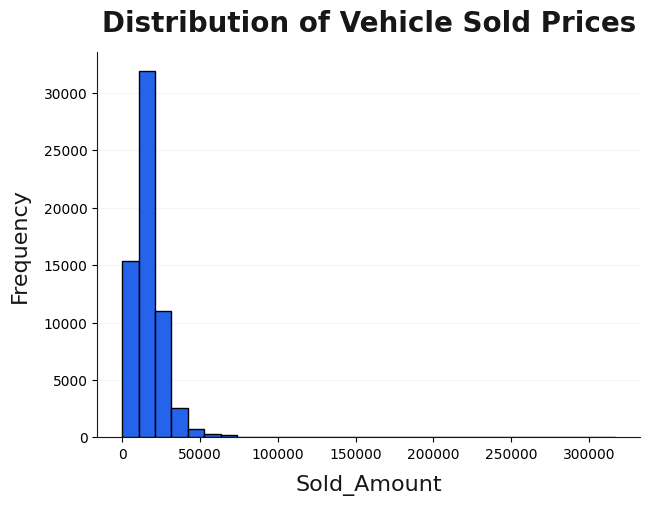

In [10]:
target_col = 'Sold_Amount'
if target_col in df.columns:
    plt.figure(figsize=(7, 5))
    plt.hist(df[target_col].dropna(), bins=30, color='#2563EB', edgecolor='black')
    plt.title('Distribution of Vehicle Sold Prices', pad=15, fontsize=20, fontweight='semibold', color='#171717')
    plt.xlabel('Sold_Amount', labelpad=10, fontsize=16, fontweight='medium', color='#171717')
    plt.ylabel('Frequency', labelpad=10, fontsize=16, fontweight='medium', color='#171717')
    plt.grid(axis='y', color='#F3F4F6')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#171717')
    ax.spines['bottom'].set_color('#171717')
    ax.set_axisbelow(True)
    plt.show()
else:
    print(f"Column '{target_col}' not found in the dataset. Available columns: ", list(df.columns))


Subset of Numeric Columns: ['AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax', 'NewPrice', 'Age_Comp_Months', 'KM', 'Sold_Amount']


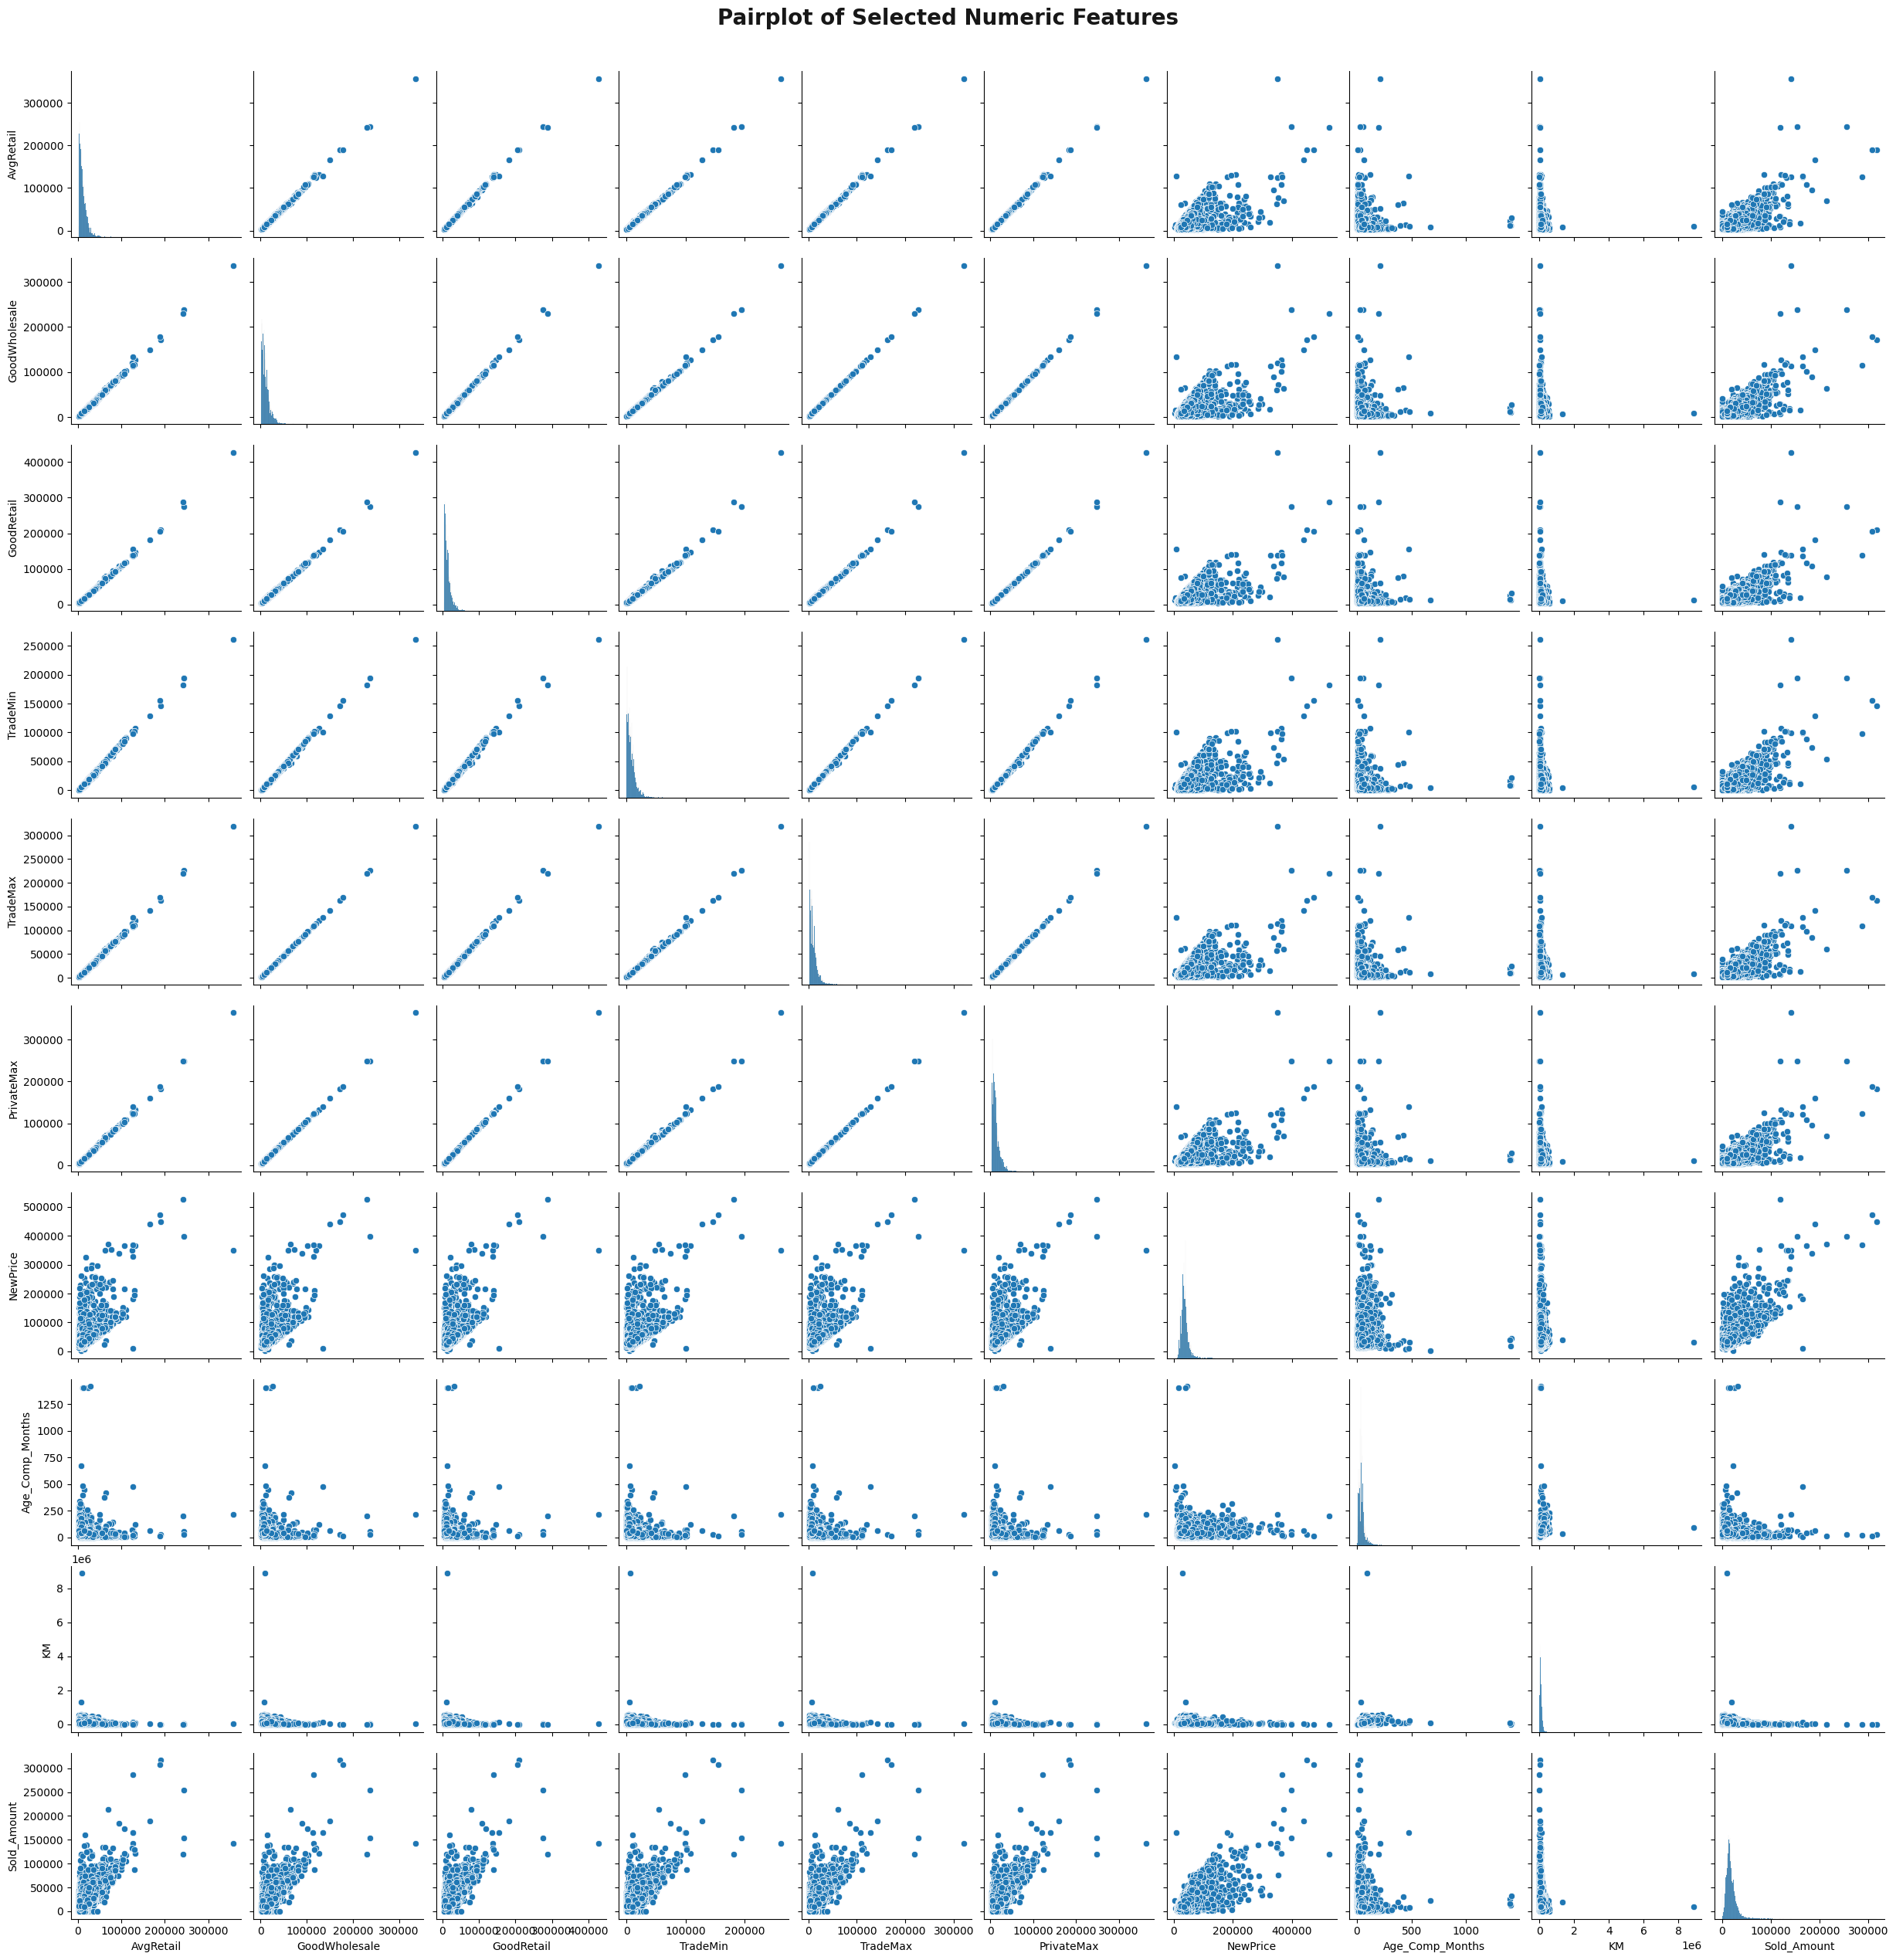

Displayed pairplot for numeric features: ['AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax', 'NewPrice', 'Age_Comp_Months', 'KM', 'Sold_Amount']


In [11]:
col_limit = 10

subset_numeric = df.select_dtypes(include=['number']).columns.tolist()[-col_limit:]
print('Subset of Numeric Columns:', subset_numeric)

# We'll create a pairplot using a subset of numeric columns if there are too many
if len(subset_numeric) >= 2:
    pairplot_fig = sns.pairplot(df.dropna(subset=subset_numeric)[subset_numeric])
    pairplot_fig.fig.suptitle('Pairplot of Selected Numeric Features', fontsize=20, fontweight='semibold', y=1.02, color='#171717')
    plt.show()
    print('Displayed pairplot for numeric features: ' + str(subset_numeric))
else:
    print('Not enough numeric columns for a pairplot.')

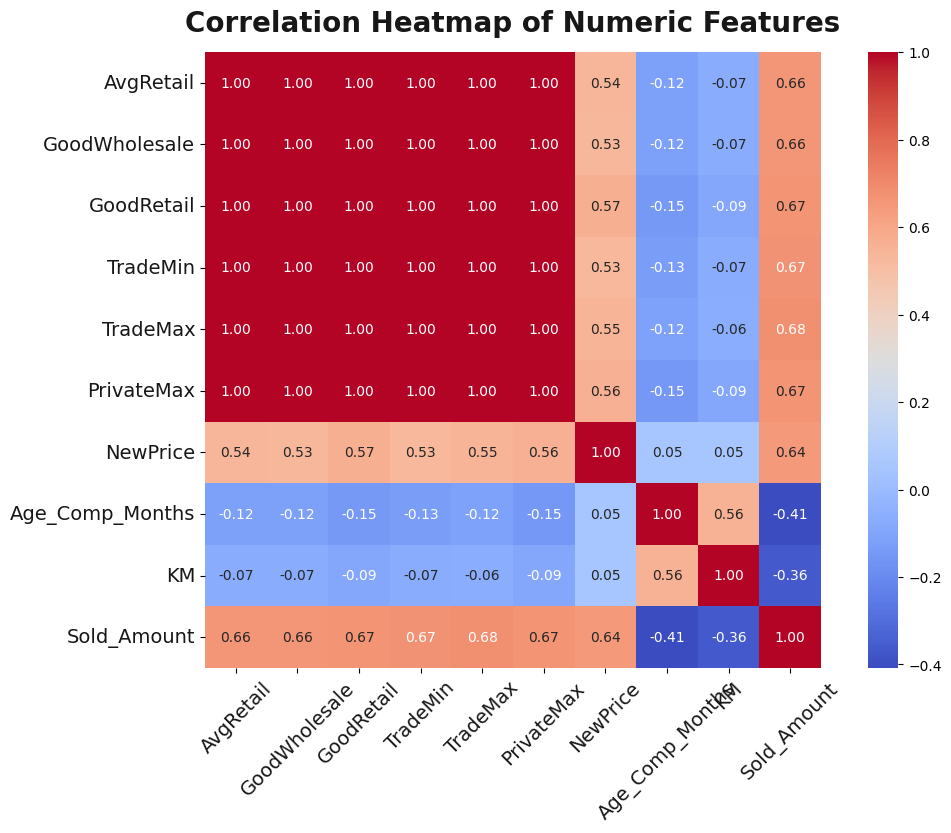

In [12]:
# Correlation heatmap for numeric features
corr = df[subset_numeric].corr()

plt.figure(figsize=(12, 8))
ax = plt.gca()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, fmt='.2f', cbar=True, square=True)
plt.title('Correlation Heatmap of Numeric Features', pad=15, fontsize=20, fontweight='semibold', color='#171717')
plt.xticks(rotation=45, fontsize=14, color='#171717')
plt.yticks(fontsize=14, color='#171717')

# Styling as described 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#171717')
ax.spines['bottom'].set_color('#171717')

plt.show()

## <a id='toc1_5_'></a>[(5) Feature Engineering & Data Preprocessing](#toc0_)

### <a id='toc1_5_1_'></a>[Drop some rows and process datetime data](#toc0_)

In [13]:
# Drop rows with missing values in 'Sold_Amount'
print("Originally, the shape of the dataframe is", df_dropped.shape)
df_cleaned = df_dropped.dropna(subset=['Sold_Amount'])
print("After removing rows with missing values in 'Sold_Amount', the shape of the dataframe is", df_cleaned.shape)

Originally, the shape of the dataframe is (62192, 111)
After removing rows with missing values in 'Sold_Amount', the shape of the dataframe is (62188, 111)


In [14]:
# Process data information into numerical value
if 'Sold_Date' in df_cleaned.columns:
    df_cleaned['Sold_Date'] = pd.to_datetime(df_cleaned['Sold_Date'], errors='coerce').copy()
    # Extract datetime features
    df_cleaned['Sold_Year'] = df_cleaned['Sold_Date'].dt.year
    df_cleaned['Sold_Month'] = df_cleaned['Sold_Date'].dt.month
    df_cleaned['Sold_Day'] = df_cleaned['Sold_Date'].dt.day
    df_cleaned['Sold_DayOfWeek'] = df_cleaned['Sold_Date'].dt.dayofweek
    # Drop original Sold_Date
    df_cleaned.drop('Sold_Date', axis=1, inplace=True)
print("After processing date information, the shape of dataframe is", df_cleaned.shape)

After processing date information, the shape of dataframe is (62188, 114)


In [15]:
# Identify categorical (object or category) and numerical columns
cat_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df_cleaned.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('Sold_Amount')

print(f"Categorical columns ({len(cat_cols)}):", cat_cols)
print(f"Numerical columns ({len(num_cols)}):", num_cols)


Categorical columns (50): ['Make', 'Model', 'Description', 'CurrentRelease', 'LimitedEdition', 'Series', 'BadgeDescription', 'BadgeSecondaryDescription', 'BodyStyleDescription', 'BodyConfigDescription', 'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 'DriveDescription', 'GearTypeDescription', 'GearLocationDescription', 'EngineDescription', 'FuelTypeDescription', 'InductionDescription', 'OptionCategory', 'CamDescription', 'EngineTypeDescription', 'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'BuildCountryOriginDescription', 'EngineCycleDescription', 'EngineConfigurationDescription', 'EngineLocation', 'FrontTyreSize', 'RearTyreSize', 'FrontRimDesc', 'RearRimDesc', 'WarrantyCustAssist', 'FreeScheduledService', 'AltEngEngineType', 'AltEngBatteryType', 'AltEngCurrentType', 'AltEngChargingMethod', 'AltEngDrive', 'ElectricEngineLocation', 'EmissionStandard', 'MaxEthanolBlend', 'VFactsClass', 'VFactsSegment', 'VFactsPrice', 'IsPPlateApproved', 'Colour', 'Branch', 'SaleCategor

### <a id='toc1_5_2_'></a>[Train-test split (80% - 20%)](#toc0_)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned.drop('Sold_Amount', axis=1),
    df_cleaned['Sold_Amount'],
    test_size=0.2,
    random_state=0,
)

## <a id='toc1_6_'></a>[(6) Encoding Categorical Data](#toc0_)

### <a id='toc1_6_1_'></a>[A) One-hot encoding method](#toc0_)

In [17]:
### max_categories need to be set properly, too low will results loss of information, too high will results in too many columns
### If set to be 5, Total number of columns with unique values exceeding the maximum allowed: 31/50
### If set to be 10, Total number of columns with unique values exceeding the maximum allowed: 21/50 (Seem to be a good balance points)
### If set to be 15, Total number of columns with unique values exceeding the maximum allowed: 19/50
### If set to be 20, Total number of columns with unique values exceeding the maximum allowed: 17/50
for max_categories in [5,10,15,20]:
    count         = 0
    for col in cat_cols:
        unique_values = X_train[col].nunique()
        if unique_values > max_categories:
            count+=1
    print(f"Total number of columns with unique values exceeding the maximum allowed: {count}")

Total number of columns with unique values exceeding the maximum allowed: 31
Total number of columns with unique values exceeding the maximum allowed: 21
Total number of columns with unique values exceeding the maximum allowed: 19
Total number of columns with unique values exceeding the maximum allowed: 17


In [18]:
# Get the top categories with high frequency for each categorical column and one-hot encoder
max_categories = 10
top_categories_dict = get_top_categories(X_train, cat_cols, max_categories=max_categories)
encoder = get_one_hot_encoder(X_train, cat_cols)

pipeline = OneHotInferencePipeline(
    top_categories_path='data/top_categories.json',
    encoder_path='data/onehot_encoder.joblib',
    num_cols=num_cols,
    cat_cols=cat_cols
)
dump(pipeline, f'{INFERENCE_PIPELINE_PATH}/One_hot_encoding_InferencePipeline.pkl')

# Transform the train and test data
X_train_OH_encoded = pipeline.transform(X_train)
X_test_OH_encoded = pipeline.transform(X_test)

# Now X_train_OH_encoded and X_test_OH_encoded have identical columns
print("Total number of columns in X_train_OH_encoded:", len(X_train_OH_encoded.columns))
print("Total number of columns in X_test_OH_encoded:", len(X_test_OH_encoded.columns))
print("Total number of X_test_OH_encoded.columns == X_train_OH_encoded.columns:", (X_test_OH_encoded.columns == X_train_OH_encoded.columns).sum())

Total number of columns in X_train_OH_encoded: 346
Total number of columns in X_test_OH_encoded: 346
Total number of X_test_OH_encoded.columns == X_train_OH_encoded.columns: 346


### <a id='toc1_6_2_'></a>[B) Target encoding method](#toc0_)

In [19]:
# Initialize the encoder and fit on training data
target_encoder = TargetEncoder(cols=cat_cols, 
                               handle_missing='return_nan', 
                               handle_unknown='value')
target_encoder.fit(X_train[cat_cols], y_train)

# Create the inference pipeline
inference_pipeline = Target_encoding_InferencePipeline(
    target_encoder=target_encoder,
    cat_cols=cat_cols,
    num_cols=num_cols
)
dump(inference_pipeline, f'{INFERENCE_PIPELINE_PATH}/Target_encoding_InferencePipeline.pkl')

# Transform both train and test dataset
X_train_T_encoded = inference_pipeline.transform(X_train)
X_test_T_encoded = inference_pipeline.transform(X_test)

# Now X_train_OH_encoded and X_test_OH_encoded have identical columns
print("Shape in X_train_T_encoded:", X_train_T_encoded.shape)
print("Shape in X_test_OH_encoded:", X_test_T_encoded.shape)
print("Total number of X_test_T_encoded.columns == X_train_T_encoded.columns:", (X_test_T_encoded.columns == X_train_T_encoded.columns).sum())


Shape in X_train_T_encoded: (49750, 113)
Shape in X_test_OH_encoded: (12438, 113)
Total number of X_test_T_encoded.columns == X_train_T_encoded.columns: 113


### <a id='toc1_6_3_'></a>[C) FeatureHasher](#toc0_)

In [20]:
# Initialize the feature hasher
n_features = 100
hasher     = FeatureHasher(n_features=n_features,input_type='string')

# Create the inference pipeline
hashing_pipeline = Feature_Hashing_InferencePipeline(
    hasher=hasher,
    cat_cols=cat_cols,
    num_cols=num_cols
)
dump(hashing_pipeline, f"{INFERENCE_PIPELINE_PATH}/Feature_Hashing_InferencePipeline.pkl")

# Transform both train and test dataset
X_train_FH_encoded = hashing_pipeline.transform(X_train)
X_test_FH_encoded = hashing_pipeline.transform(X_test)

# Now X_train_OH_encoded and X_test_OH_encoded have identical columns
print("Shape in X_train_T_encoded:", X_train_FH_encoded.shape)
print("Shape in X_test_FH_encoded:", X_test_FH_encoded.shape)
print("Total number of X_test_FH_encoded.columns == X_train_FH_encoded.columns:", (X_test_FH_encoded.columns == X_train_FH_encoded.columns).sum())


Shape in X_train_T_encoded: (49750, 163)
Shape in X_test_FH_encoded: (12438, 163)
Total number of X_test_FH_encoded.columns == X_train_FH_encoded.columns: 163


## <a id='toc1_7_'></a>[(7) Model Building & Training](#toc0_)

In [21]:
# Hyperparameter tuning 
n_iter = 10
param_distributions = {
    'HistGradientBoosting': {
        'model': HistGradientBoostingRegressor(random_state=0),
        'params': {
            'learning_rate': [0.1, 0.05, 0.01],
            'max_iter': [100, 300, 1000],
            'max_depth': [None, 10, 20],
            'l2_regularization': [0.0, 0.1, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=0, n_jobs=-1),
        'params': {
            'max_depth': [3, 6, 10],
            'learning_rate': [0.1, 0.05, 0.01],
            'n_estimators': [100, 500, 1000],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=0, silent=True),
        'params': {
            'depth': [6, 8, 10],
            'learning_rate': [0.1, 0.05, 0.01],
            'iterations': [100, 500, 1000]
        }
    }
}



In [22]:
# Initialize a dictionary to store metrics for each encoding strategy
final_results = {}

# Loop over encoding strategies
for save_dir, x_train, x_test in [('models/One_hot_encoding', X_train_OH_encoded, X_test_OH_encoded), 
                                  ('models/Target_encoding', X_train_T_encoded, X_test_T_encoded), 
                                  ('models/Feature_hashing', X_train_FH_encoded, X_test_FH_encoded)]:
    print("Running for", save_dir.split('/')[-1].replace('_', ' '))
    encoding_metrics = {}
    
    # Loop over each model configuration & Train and get predictions from best model
    for name, config in param_distributions.items():
        best_model, y_pred = tune_and_save_model(
            name, config['model'], config['params'],
            x_train, y_train, x_test,
            n_iter=n_iter,
            save_dir=save_dir
        )
        
        # Get metrics for the current model
        category_metrics = evaluate_model(y_test, y_pred, 
                                          category_to_slice=X_test['Make'])
        encoding_metrics[name] = category_metrics

    # Convert to structured DataFrame
    results_list = []
    for model_name, makes in encoding_metrics.items():
        for make, metrics in makes.items():
            results_list.append({'Model': model_name, 'Make': make, 'R²': metrics['R2'],
                                 'RMSE': metrics['RMSE'],'MAE': metrics['MAE']  })
    
    results_df = pd.DataFrame(results_list)
    
    # Formatting improvements
    results_df = results_df.round(3)
    results_df = results_df.set_index(['Model', 'Make'])
    
    # Store and display
    final_results[save_dir] = results_df

Running for One hot encoding
> > > Tuning HistGradientBoosting...


> > > Tuning XGBoost...
> > > Tuning CatBoost...
Running for Target encoding
> > > Tuning HistGradientBoosting...
> > > Tuning XGBoost...
> > > Tuning CatBoost...
Running for Feature hashing
> > > Tuning HistGradientBoosting...
> > > Tuning XGBoost...
> > > Tuning CatBoost...


## <a id='toc1_8_'></a>[(8) Model Evaluation](#toc0_)

In [23]:
## Display the results
final_results = pd.concat(final_results.values(), 
                       axis=1)
multi_index = [
    ('One-hot encoding', 'R²'),
    ('One-hot encoding', 'RMSE'),
    ('One-hot encoding', 'MAE'),
    ('Target encoding', 'R²'),
    ('Target encoding', 'RMSE'),
    ('Target encoding', 'MAE'),
    ('Feature hashing', 'R²'),
    ('Feature hashing', 'RMSE'),
    ('Feature hashing', 'MAE')
]
final_results.columns = pd.MultiIndex.from_tuples(multi_index)
styled_df = final_results.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#404040'), 
                                     ('color', 'white'),
                                     ('font-weight', 'bold'), 
                                     ('border', '1px solid white')]}
    ])\
    .format({'R²': '{:.2f}', 'RMSE': '{:.2f}', 'MAE': '{:.2f}'})\
    .background_gradient(subset=multi_index, cmap='BuGn')
display(styled_df)

## <a id='toc1_9_'></a>[(9) Features Important Analysis](#toc0_)

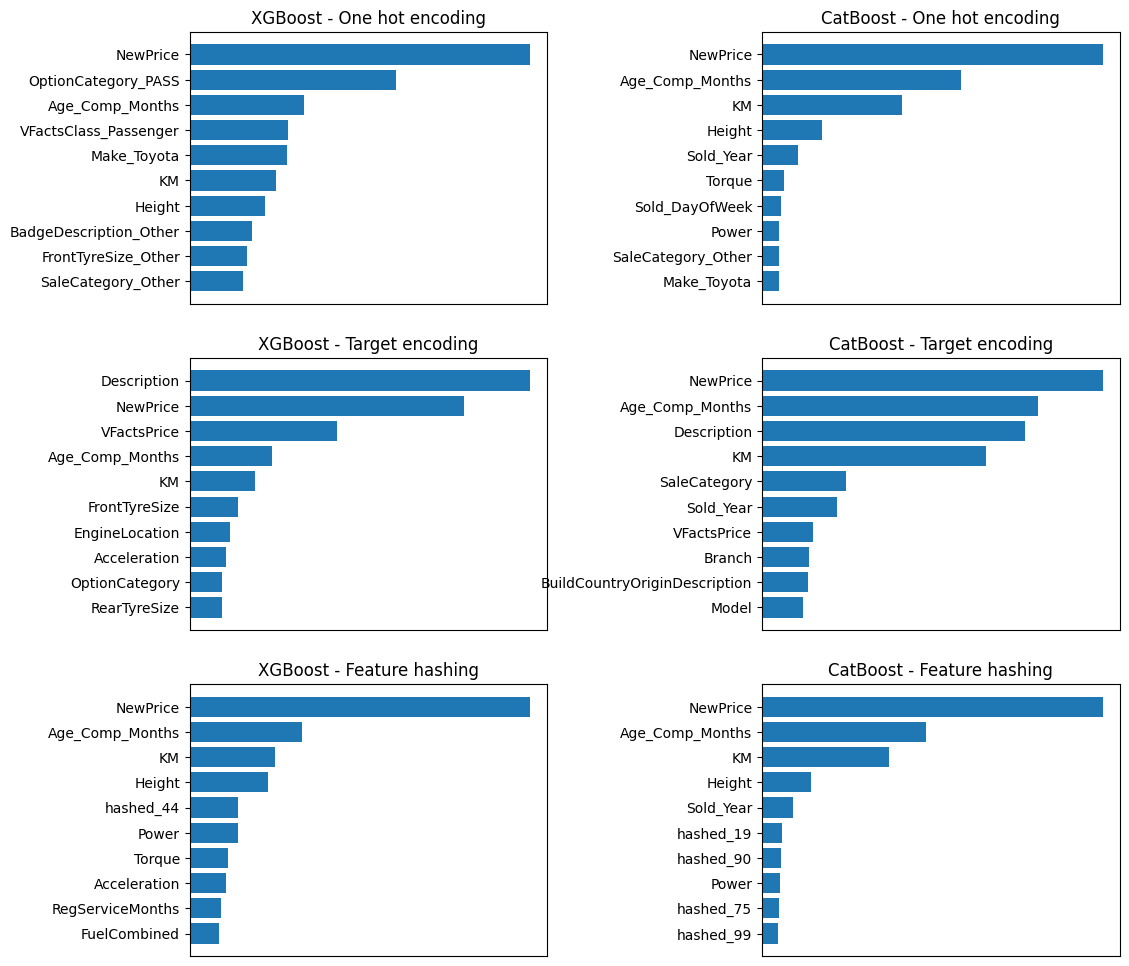

In [24]:
def plot_importance(ax, values, title, features_name, num_values_shown=10):
    sorted_idx = np.argsort(values)
    values_to_plot = np.array(values)[sorted_idx][-num_values_shown:]
    labels_to_plot = features_name[sorted_idx][-num_values_shown:]

    ax.barh(range(num_values_shown), values_to_plot)
    ax.set_xticks([])
    ax.set_yticks(range(num_values_shown))
    ax.set_yticklabels(labels_to_plot)
    ax.set_title(title)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.subplots_adjust(wspace=0.6) 
# fig.tight_layout(pad=5.0)

for i, (save_dir, x_train, x_test) in enumerate([
    ('models/One_hot_encoding', X_train_OH_encoded, X_test_OH_encoded), 
    ('models/Target_encoding', X_train_T_encoded, X_test_T_encoded), 
    ('models/Feature_hashing', X_train_FH_encoded, X_test_FH_encoded)]):

    encoding_name = save_dir.split('/')[-1].replace('_', ' ')
    features_name = x_train.columns

    # XGBoost
    XGBoost_model = load(f'{save_dir}/XGBoost_best_model.pkl')
    xgb_importance = XGBoost_model.feature_importances_
    plot_importance(ax[i, 0], xgb_importance, f'XGBoost - {encoding_name}', features_name)

    # CatBoost
    CatBoost_model = load(f'{save_dir}/CatBoost_best_model.pkl')
    cat_importance = CatBoost_model.get_feature_importance()
    plot_importance(ax[i, 1], cat_importance, f'CatBoost - {encoding_name}', features_name)

plt.show()

## <a id='toc1_10_'></a>[(10) Inference Pipeline](#toc0_)

In [25]:
def load_model_and_predict(model_name, X_input, model_dir="models"):
    model_path = f"{model_dir}/{model_name}_best_model.pkl"
    model = load(model_path)
    return model.predict(X_input)

# Sample input without 'Sold_Amount' column
sample_input = pd.read_csv('sample_input.csv')
sample_input['Make'] = "Porte" # Add a new 'Make' category

print("Sample input:", sample_input.shape)
sample_input

Sample input: (3, 129)


,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,...,TradeMax,PrivateMax,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM
0,Porte,Falcon,FORD,FALCON,2005,0,1,BA Mk II XT Sedan 4dr Spts Auto 4sp 4.0i,F,L,...,NaN,4100.0,35555.0,Mercury Silver,Belmore (NSW),Fixed Price,2008-08-31 00:00:00.000,03/2005,41.0,60255.0
1,Porte,Ranger,FORD,RANGER,2013,0,27,PX XL Utility Double Cab 4dr Spts Auto 6sp 4x4...,F,L,...,25800.0,30600.0,48390.0,Silver,Belmore (NSW),Auction,2014-10-07 00:00:00.000,12/2013,10.0,53346.0
2,Porte,Tarago,TOYO,TARAGO,2007,0,0,ACR50R GLi Wagon 8st 5dr Spts Auto 4sp 2.4i,F,L,...,9700.0,12400.0,49490.0,Silver,Hobart (TAS),Special Fixed Price,2009-05-23 00:00:00.000,01/2007,28.0,44355.0


In [26]:
# Encoding and models list
encodings = ['Target_encoding', 'Feature_hashing', 'One_hot_encoding']
models = ['HistGradientBoosting', 'CatBoost', 'XGBoost']

results = []
for encoding in encodings:
    # Load the encoding pipeline and transform the sample input
    preprocess_pipeline = load(f'{INFERENCE_PIPELINE_PATH}/{encoding}_InferencePipeline.pkl')
    sample_input_encoded = preprocess_pipeline.transform(sample_input)

    # Iterate through models and make predictions
    for model_name in models:
        # Predict with the current model
        y_pred = load_model_and_predict(model_name, sample_input_encoded, model_dir=f'models/{encoding}')
        y_pred = np.round(y_pred, 2)

        # Store the result in the DataFrame
        result = {'Encoding': encoding, 'Model': model_name,'Prediction': y_pred}
        results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,Encoding,Model,Prediction
0,Target_encoding,HistGradientBoosting,"[12604.45, 34470.97, 31347.94]"
1,Target_encoding,CatBoost,"[11568.81, 35077.77, 31169.34]"
2,Target_encoding,XGBoost,"[12274.24, 34570.51, 32115.95]"
3,Feature_hashing,HistGradientBoosting,"[11354.08, 34099.12, 30710.75]"
4,Feature_hashing,CatBoost,"[11231.61, 34473.39, 30298.24]"
5,Feature_hashing,XGBoost,"[11006.46, 35020.4, 30881.68]"
6,One_hot_encoding,HistGradientBoosting,"[12408.39, 34227.44, 29452.41]"
7,One_hot_encoding,CatBoost,"[11471.37, 34228.94, 29208.28]"
8,One_hot_encoding,XGBoost,"[11278.22, 33596.58, 30602.26]"
